In [18]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import math
import pandas as pd
import sys
from sklearn.preprocessing import StandardScaler
sys.path.append('../src')
from utils import *
import data_loader

In [19]:
# load dataset
df = data_loader.load_logistic_regression_data('../data/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

# Sample N benign and N DDoS examples
N = 200  
benign_df = df[df['Label'] == 'BENIGN'].sample(n=N, random_state=42)
ddos_df = df[df['Label'] == 'DDoS'].sample(n=N, random_state=42)

# Combine and shuffle
sample_df = pd.concat([benign_df, ddos_df]).sample(frac=1, random_state=42)

# Prepare training data
y_train = (sample_df['Label'] == 'DDoS').astype(int).to_numpy() # 1 for DDoS, 0 for BENIGN
feature_columns = ['Packet Length Mean', 'Bwd Packet Length Mean']
X_train = sample_df[feature_columns].to_numpy()

In [20]:
# Function for plotting data on a 2D plot
def plot_data(X, y, pos_label="y=1", neg_label="y=0"):
    positive = y == 1
    negative = y == 0

    # Plot Benign first
    plt.plot(X[negative, 0], X[negative, 1], 'yo', label=neg_label, markersize=6)
    # Plot DDoS on top
    plt.plot(X[positive, 0], X[positive, 1], 'k+', label=pos_label, markersize=8)


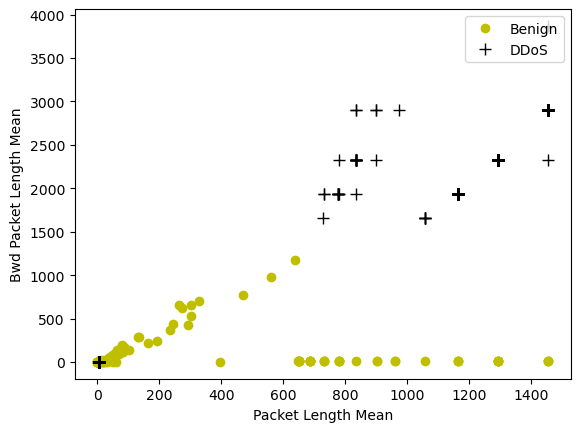

In [21]:
# Plot examples
plot_data(X_train, y_train[:], pos_label="DDoS", neg_label="Benign")

# Set the y-axis label
plt.ylabel('Bwd Packet Length Mean')
# Set the x-axis label
plt.xlabel('Packet Length Mean')
plt.legend(loc="upper right")
plt.show()

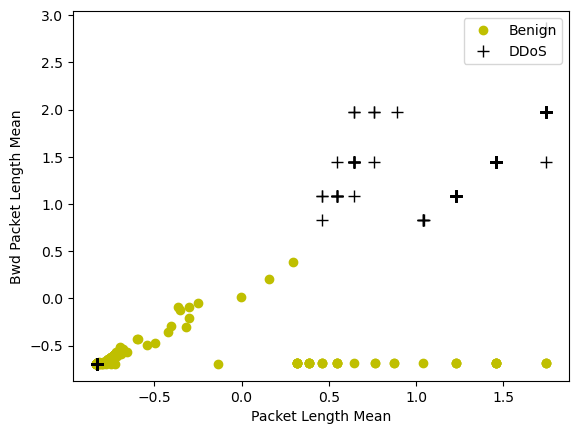

In [23]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Plot of scaled features
# Plot examples
plot_data(X_train_scaled, y_train[:], pos_label="DDoS", neg_label="Benign")

# Set the y-axis label
plt.ylabel('Bwd Packet Length Mean')
# Set the x-axis label
plt.xlabel('Packet Length Mean')
plt.legend(loc="upper right")
plt.show()

In [24]:
def map_feature(X1, X2):
    """
    Feature mapping function to polynomial features    
    """
    X1 = np.atleast_1d(X1)
    X2 = np.atleast_1d(X2)
    degree = 6
    out = []
    for i in range(1, degree+1):
        for j in range(i + 1):
            out.append((X1**(i-j) * (X2**j)))
    return np.stack(out, axis=1)

# Map the features
mapped_X = map_feature(X_train_scaled[:, 0], X_train_scaled[:, 1])
print("Shape after feature mapping:", mapped_X.shape)

Shape after feature mapping: (400, 27)


In [22]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Args:
        z (ndarray): A scalar, numpy array of any size.

    Returns:
        g (ndarray): sigmoid(z), with the same shape as z
         
    """
          
    g = 1/(1+np.exp(-z))
       
    return g

In [25]:
def compute_cost(X, y, w, b, lambda_=0.1):
    """
    Computes the regularized cost over all examples
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (ndarray Shape (m,))  target value 
      w : (ndarray Shape (n,))  values of parameters of the model      
      b : (scalar)              value of bias parameter of the model
      lambda_ : (scalar, float) Controls amount of regularization (default 0.1)
    Returns:
      total_cost : (scalar) cost 
    """
    m, n = X.shape
    total_cost = 0.0
    epsilon = 1e-8  # small value to avoid log(0)
    for i in range(m):
        z_i = np.dot(X[i], w) + b
        f_wb_i = sigmoid(z_i)
        f_wb_i = np.clip(f_wb_i, epsilon, 1 - epsilon)
        total_cost += -y[i]*np.log(f_wb_i) - (1-y[i])*np.log(1-f_wb_i)
    total_cost = total_cost / m
    reg_cost = (lambda_ / (2 * m)) * np.sum(w**2)
    total_cost += reg_cost
    return total_cost

In [31]:
def compute_gradient(X, y, w, b, lambda_=1.0):
    """
    Computes the gradient for regularized logistic regression

    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (ndarray Shape (m,))  target value 
      w : (ndarray Shape (n,))  values of parameters of the model      
      b : (scalar)              value of bias parameter of the model
      lambda_ : (scalar,float)  regularization constant
    Returns:
      dj_db : (scalar)             The gradient of the cost w.r.t. the parameter b. 
      dj_dw : (ndarray Shape (n,)) The gradient of the cost w.r.t. the parameters w. 
    """
    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0.

    for i in range(m):
        z_wb = np.dot(X[i], w) + b
        f_wb = sigmoid(z_wb)
        dj_db_i = f_wb - y[i]
        dj_db += dj_db_i
        dj_dw += dj_db_i * X[i]

    dj_dw = dj_dw / m
    dj_db = dj_db / m

    # Regularization for dj_dw (not for bias)
    dj_dw += (lambda_ / m) * w

    return dj_db, dj_dw

In [32]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X :    (ndarray Shape (m, n) data, m examples by n features
      y :    (ndarray Shape (m,))  target value 
      w_in : (ndarray Shape (n,))  Initial values of parameters of the model
      b_in : (scalar)              Initial value of parameter of the model
      cost_function :              function to compute cost
      gradient_function :          function to compute gradient
      alpha : (float)              Learning rate
      num_iters : (int)            number of iterations to run gradient descent
      lambda_ : (scalar, float)    regularization constant
      
    Returns:
      w : (ndarray Shape (n,)) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """
    
    # number of training examples
    m = len(X)
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)   

        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw               
        b_in = b_in - alpha * dj_db              
       
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w_in, b_in, J_history, w_history #return w and J,w history for graphing

In [33]:
# Initialize fitting parameters
np.random.seed(1)
initial_w = np.random.rand(mapped_X.shape[1])-0.5
initial_b = 1.

# Set regularization parameter lambda_ 
lambda_ = 0.1    

# Some gradient descent settings
iterations = 10000
alpha = 0.01

w,b, J_history,_ = gradient_descent(mapped_X, y_train, initial_w, initial_b, 
                                    compute_cost_reg, compute_gradient_reg, 
                                    alpha, iterations, lambda_)

Iteration    0: Cost     1.16   
Iteration 1000: Cost     0.42   
Iteration 2000: Cost     0.39   
Iteration 3000: Cost     0.38   
Iteration 4000: Cost     0.37   
Iteration 5000: Cost     0.36   
Iteration 6000: Cost     0.35   
Iteration 7000: Cost     0.34   
Iteration 8000: Cost     0.34   
Iteration 9000: Cost     0.34   
Iteration 9999: Cost     0.33   


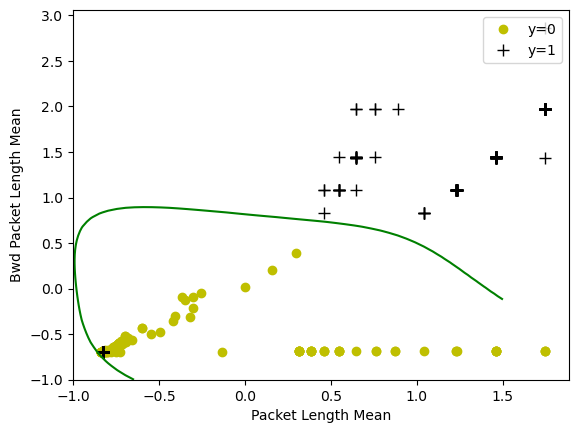

In [34]:
plot_decision_boundary(w, b, mapped_X, y_train)
# Set the y-axis label
plt.ylabel('Bwd Packet Length Mean')
# Set the x-axis label
plt.xlabel('Packet Length Mean')
plt.legend(loc="upper right")
plt.show()

In [ ]:
def predict(X, w, b): 
    """
    Predict whether the label is 0 or 1 using learned logistic
    regression parameters w
    
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      w : (ndarray Shape (n,))  values of parameters of the model      
      b : (scalar)              value of bias parameter of the model

    Returns:
      p : (ndarray (m,)) The predictions for X using a threshold at 0.5
    """
    # number of training examples
    m, n = X.shape   
    p = np.zeros(m)
   
    # Loop over each example
    for i in range(m):   
        z_wb = 0
        # Loop over each feature
        for j in range(n): 
            # Add the corresponding term to z_wb
            z_wb += w[j] * X[i,j]
        
        # Add bias term 
        z_wb += b
        
        # Calculate the prediction for this example
        f_wb = sigmoid(z_wb)

        # Apply the threshold
        p[i] = 1 if f_wb >= 0.5 else 0
        
    return p

#Compute accuracy on the training set
p = predict(mapped_X, w, b)

print('Train Accuracy: %f'%(np.mean(p == y_train) * 100))

Example 0: Predicted=1, Actual=1
Example 1: Predicted=0, Actual=1
Example 2: Predicted=0, Actual=0
Example 3: Predicted=1, Actual=1
Example 4: Predicted=0, Actual=0
Example 5: Predicted=0, Actual=0
Example 6: Predicted=1, Actual=1
Example 7: Predicted=0, Actual=0
Example 8: Predicted=1, Actual=1
Example 9: Predicted=0, Actual=0
Example 10: Predicted=0, Actual=0
Example 11: Predicted=0, Actual=1
Example 12: Predicted=0, Actual=0
Example 13: Predicted=0, Actual=0
Example 14: Predicted=0, Actual=0
Example 15: Predicted=0, Actual=0
Example 16: Predicted=1, Actual=1
Example 17: Predicted=0, Actual=1
Example 18: Predicted=1, Actual=1
Example 19: Predicted=0, Actual=1
Example 20: Predicted=0, Actual=0
Example 21: Predicted=0, Actual=0
Example 22: Predicted=0, Actual=1
Example 23: Predicted=0, Actual=1
Example 24: Predicted=0, Actual=0
Example 25: Predicted=1, Actual=1
Example 26: Predicted=0, Actual=0
Example 27: Predicted=0, Actual=1
Example 28: Predicted=0, Actual=1
Example 29: Predicted=0,